In [1]:
from __future__ import print_function
from __future__ import division
import matplotlib.pyplot as plt
import time
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import transforms
import importlib
import roofnet.utils.data as roof
import TripletLoss

In [2]:
data_dir = "C:\\Users\\Simas\\Documents\\Github\\RoofNet"
model_dir = "C:\\Users\\Simas\\Documents\\Github\\RoofNet\\saved_models"

# Initialize Model

In [3]:
# Size of latent space
latent_space = 128

# Number of epochs to train for
num_epochs = 1

In [4]:
model = TripletLoss.Model(input_shape=255, latent_space = latent_space, dropout = 0.1)

# Initialize Data

In [5]:
data_file_path = data_dir + "\\train_hard.npy"
data = roof.ImageDataset(data_file_path, 
                    transform=transforms.Compose([
                                transforms.ToPILImage(mode='RGB'),
                                transforms.ColorJitter(0.5,0.5,0.5,0),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #Resnet Normalization
                            ]))

val_data_file_path = data_dir + "\\test_easy.npy"
val_data = roof.ImageDataset(val_data_file_path, 
                    transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #Resnet Normalization
                            ]))

Loading data
Done loading data
Length 2765
Num Roofs 395
Loading data
Done loading data
Length 210
Num Roofs 30


In [6]:
BATCH_SIZE = 16
NUM_BATCHES = 200
VAL_BATCHES = 100

sampler = roof.TripletBuildingSampler(data,batch_size=BATCH_SIZE*NUM_BATCHES)
loader = torch.utils.data.DataLoader(data, sampler=sampler,batch_size=BATCH_SIZE*3)

val_sampler = roof.TripletBuildingSampler(val_data,batch_size=BATCH_SIZE*VAL_BATCHES)
val_loader = torch.utils.data.DataLoader(val_data, sampler=val_sampler,batch_size=BATCH_SIZE*3)

In [18]:
hist, train_loss, score = model.train_model(loader, val_loader, 0.0, num_epochs)

Epoch 0/0
----------
train Loss: 2.1735 Acc: 0.5994
val Loss: 1.3361 Acc: 0.7412

Training complete in 4m 18s
Best val Acc: 0.741250


In [7]:
model.load(model_dir+'\\Hard Train 0_5_10 Margin Easy Val Dropout Jitter')

# Use validation data to generate predictions

In [8]:
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=7, shuffle=False)

In [10]:
latents, meta = model.get_latents(val_data)

In [20]:
n = 0

In [21]:
meta[0]

{'address': '6115 Fallbrook Ave, Woodland Hills, CA 91367, USA',
 'transition_year': 2018}

In [22]:
hold = []
for i in latents[0]:
    hold.append(np.linalg.norm(i))
hold

[5.5173793, 8.045501, 6.7212424, 5.3437424, 6.6017027, 5.31049, 7.358272]

In [23]:
diff = []
for i in range(6):
    diff.append(np.linalg.norm(latents[n][i]-latents[n][i+1]))
diff

[6.2530107, 4.94343, 5.415941, 4.9267106, 4.590102, 6.360127]

In [118]:
out = []
for i in range(len(latents)):
    pred = np.argmax([np.linalg.norm(latents[i][j]-latents[i][j+1]) for j in range(6)])+2013
    out.append([meta[i]['address'],pred,meta[i]['transition_year']])
out = np.array(out)

In [119]:
out

array([['6115 Fallbrook Ave, Woodland Hills, CA 91367, USA', '2018',
        '2018'],
       ['5350 Venice Blvd, Los Angeles, CA 90019, USA', '2018', '2017'],
       ['16604 Arminta St, Van Nuys, CA 91406, USA', '2014', '2018'],
       ['1600 E Olympic Blvd, Los Angeles, CA 90021, USA', '2018',
        '2018'],
       ['3932 Wilshire Blvd, Los Angeles, CA 90010, USA', '2018', '2017'],
       ['4375 Glencoe Ave, Marina Del Rey, CA 90292, USA', '2018',
        '2018'],
       ['1501 E 41st St, Los Angeles, CA 90011, USA', '2018', '2017'],
       ['1390 186th St, Gardena, CA 90248, USA', '2018', '2018'],
       ['4265 S Broadway, Los Angeles, CA 90037, USA', '2018', '2018'],
       ['1700 S Western Ave, Los Angeles, CA 90006, USA', '2018', '2014'],
       ['1330 E Mauretania St, Wilmington, CA 90744, USA', '2018',
        '2018'],
       ['545 N Commonwealth Ave, Los Angeles, CA 90004, USA', '2018',
        '2014'],
       ['4020 Paloma St, Los Angeles, CA 90011, USA', '2018', '2018'],
  

In [120]:
np.mean(out[:,1]==out[:,2])

0.4

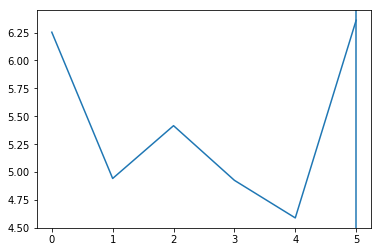

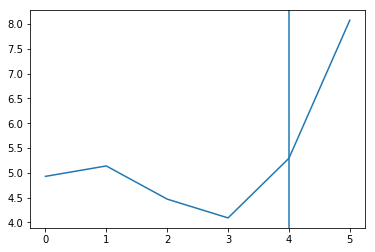

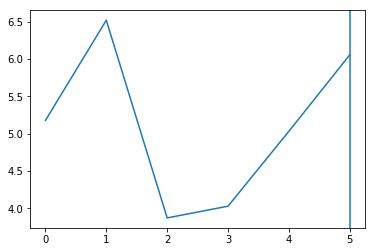

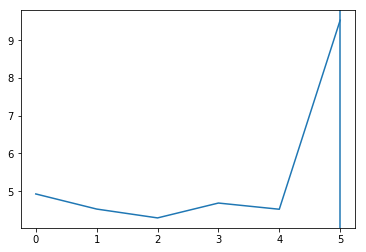

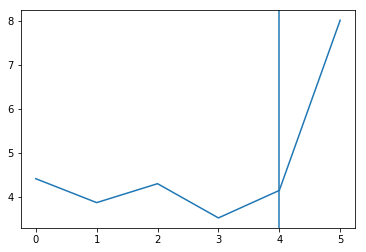

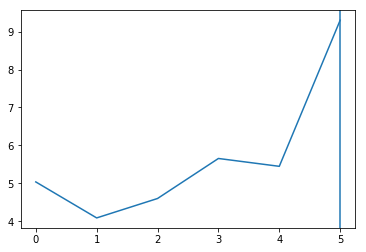

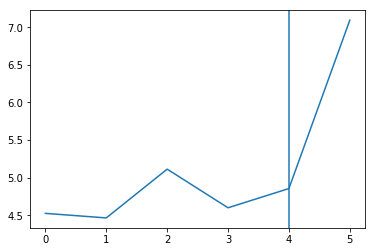

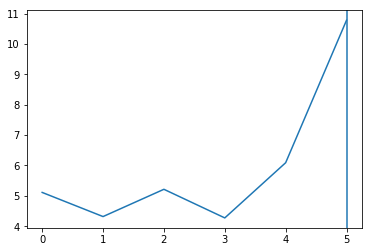

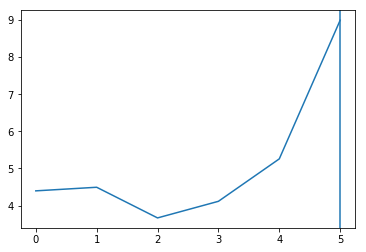

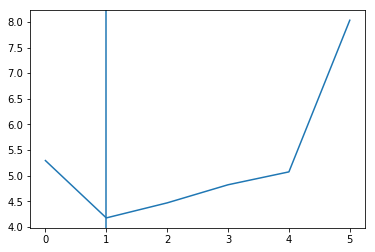

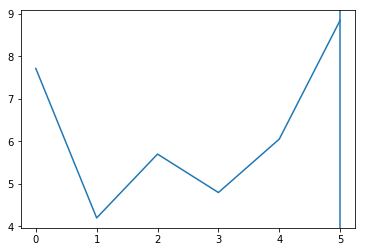

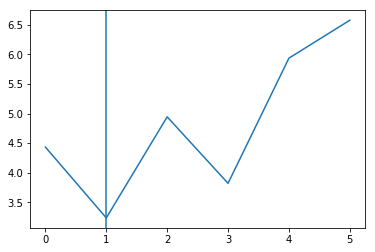

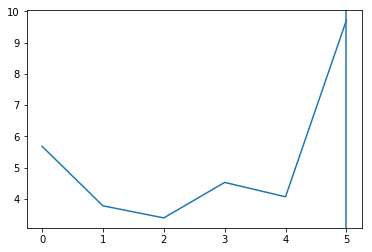

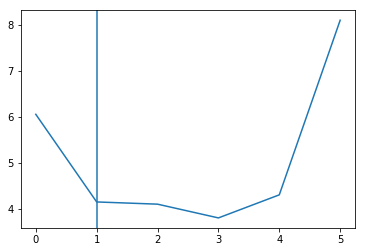

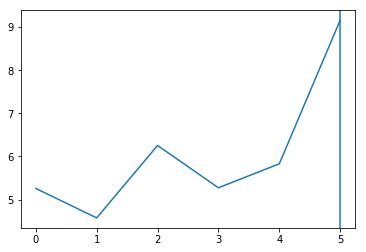

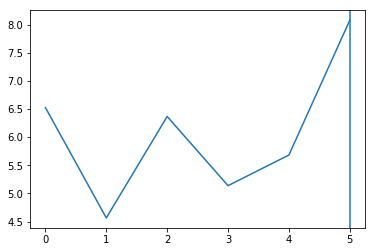

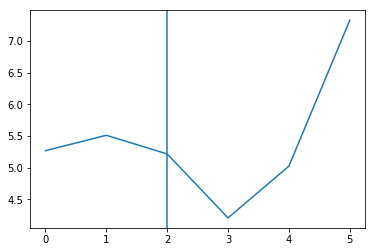

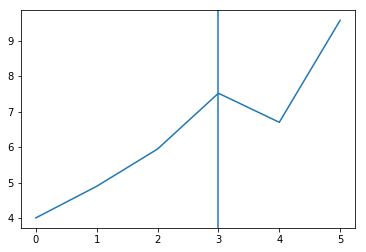

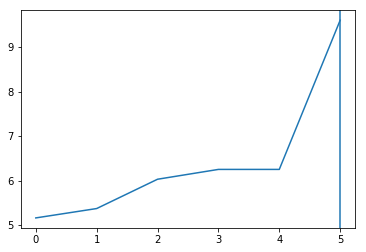

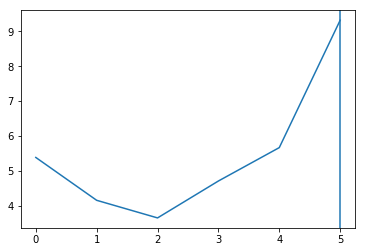

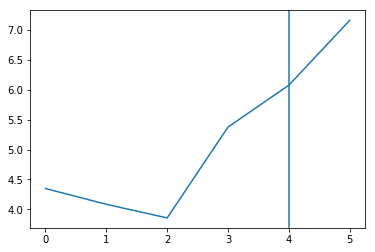

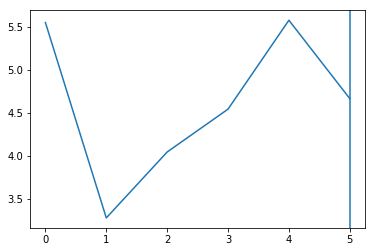

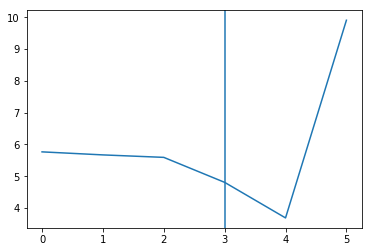

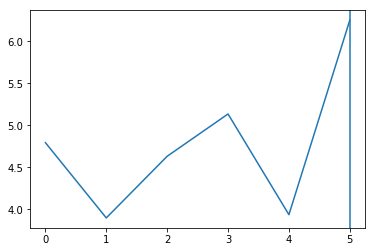

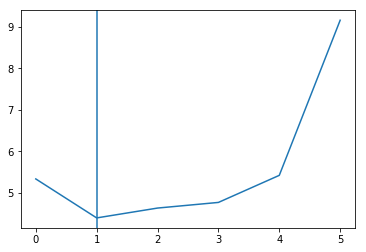

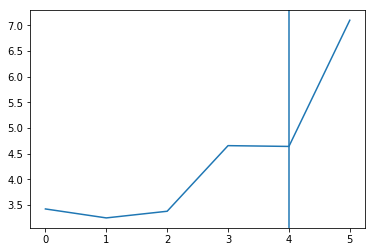

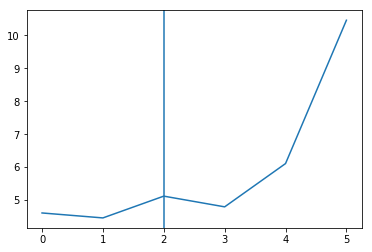

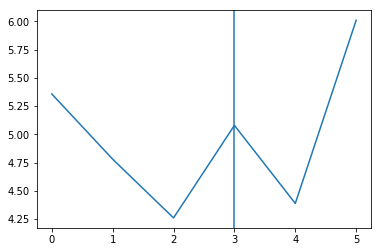

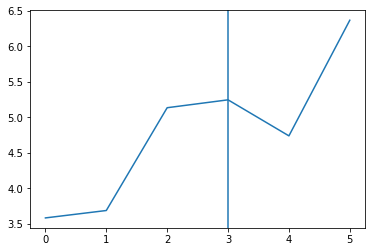

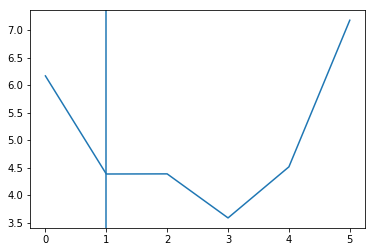

In [117]:

for j in range(len(latents)):
    diff = []
    for i in range(6):
        diff.append(np.linalg.norm(latents[j][i]-latents[j][i+1]))
    plt.plot(diff)
    plt.axvline(meta[j]['transition_year']-2013)
    plt.show()

In [12]:
data_array = TripletLoss.make_data_array(val_data)

In [34]:
from sklearn.decomposition import PCA

In [43]:
meta[3]

{'address': '1600 E Olympic Blvd, Los Angeles, CA 90021, USA',
 'transition_year': 2018}

In [35]:
pca = PCA(n_components=4)
pca.fit(latents[3])  

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [36]:
print(pca.explained_variance_ratio_) 

[0.53491807 0.15383676 0.11184567 0.0809867 ]


In [37]:
print(pca.singular_values_) 

[8.020162  4.301001  3.6673222 3.120659 ]


In [47]:
latents[3].reshape(7,-1).shape

(7, 128)

In [38]:
temp = pca.transform(latents[3])
temp_x = temp[:,0]
temp_y = temp[:,1]

In [39]:
temp_x

array([ 0.8811525 , -0.03377048, -2.1718266 , -2.1837006 , -1.2591538 ,
       -2.1501675 ,  6.9174676 ], dtype=float32)

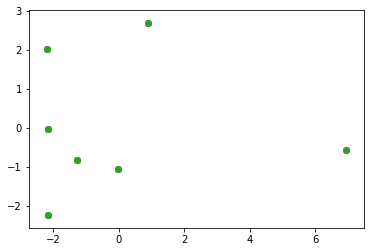

In [42]:
plt.scatter(temp_x,temp_y)
plt.show()

In [57]:
temp_x

array([-1.9721566 , -0.61318207,  0.05797387, -1.7529069 , -0.67843467,
       -2.3229837 ,  7.281689  ], dtype=float32)

In [48]:
all_data = []
for i in latents:
    all_data.extend(i)
all_data= np.array(all_data)

In [49]:
all_data.shape

(210, 128)

In [66]:
pca = PCA(n_components=42)

In [67]:
temp = pca.fit_transform(all_data)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.20093971 0.09734917 0.05540358 0.04472888 0.04224475 0.0387564
 0.03735937 0.02930706 0.02585711 0.02328012 0.021796   0.01938044
 0.01920072 0.01702435 0.01527366 0.01470217 0.01383772 0.01364814
 0.01238851 0.01191586 0.0106443  0.01007568 0.00976484 0.00925287
 0.00842179 0.00817746 0.00770889 0.00706806 0.00698766 0.00654582
 0.0061358  0.00602317 0.00575486 0.00571547 0.00550202 0.00536713
 0.004939   0.00479203 0.0046716  0.00439848 0.00428199 0.00410099]
0.9007236524485052


In [68]:
temp_x = temp[:,0]
temp_y = temp[:,1]

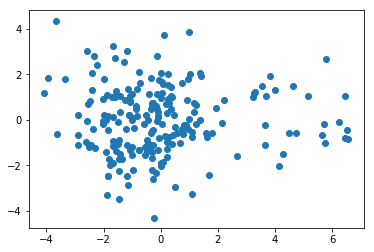

In [69]:
plt.scatter(temp_x,temp_y)
plt.show()

In [82]:
pca = PCA(n_components=42)
pca.fit_transform(all_data)
print(sum(pca.explained_variance_ratio_)) 

0.9007235448807478


In [70]:
from sklearn import mixture

In [71]:
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full')

In [73]:
gmm.fit(temp)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [111]:
n = 6

In [112]:
meta[n]

{'address': '1501 E 41st St, Los Angeles, CA 90011, USA',
 'transition_year': 2017}

In [113]:
gmm.predict(pca.transform(latents[n]))

array([1, 1, 1, 1, 1, 1, 0], dtype=int64)

In [103]:
cluster_hold = gmm.predict(temp)

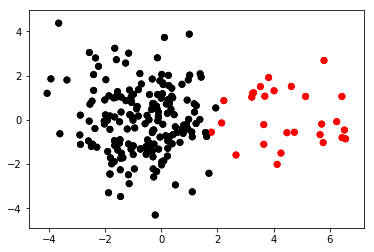

In [99]:
plt.scatter(temp[:,0], temp[:,1], color=color)
plt.show()

In [97]:
color = ['black' if i==1 else 'red' for i in cluster_hold ]